Take from GABRIEL ATKIN Fish Image Species Classification

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

2021-11-08 14:59:06.574065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
image_dir = Path('../input/flowers-recognition/flowers')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [3]:
image_df.head(5)

,Filepath,Label
0,../input/flowers-recognition/flowers/dandelion...,dandelion
1,../input/flowers-recognition/flowers/dandelion...,dandelion
2,../input/flowers-recognition/flowers/dandelion...,dandelion
3,../input/flowers-recognition/flowers/dandelion...,dandelion
4,../input/flowers-recognition/flowers/dandelion...,dandelion


In [4]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,../input/flowers-recognition/flowers/dandelion...,dandelion
1,../input/flowers-recognition/flowers/dandelion...,dandelion
2,../input/flowers-recognition/flowers/dandelion...,dandelion
3,../input/flowers-recognition/flowers/tulip/889...,tulip
4,../input/flowers-recognition/flowers/tulip/347...,tulip


In [5]:
image_df.shape

(4317, 2)

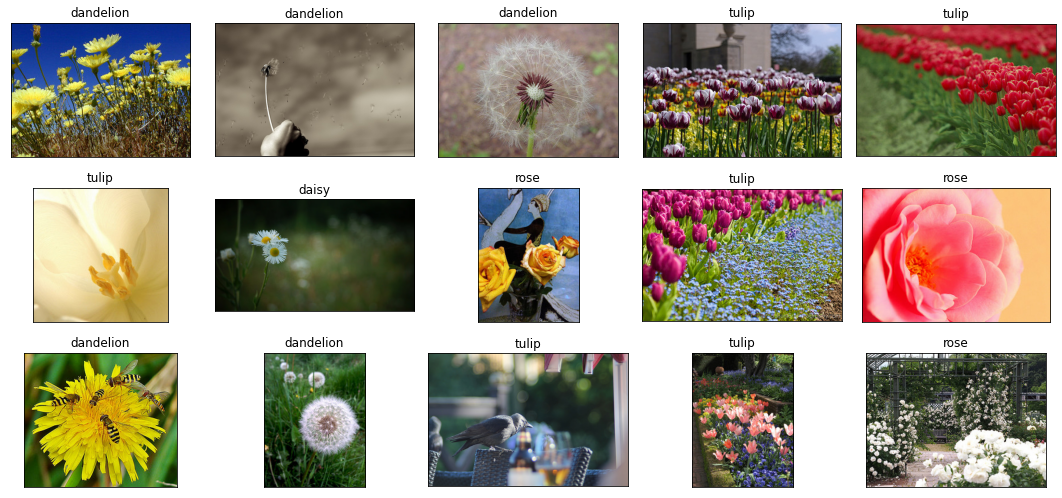

In [6]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [8]:
train_df.shape

(3885, 2)

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [10]:
train_df.head(5)

,Filepath,Label
3808,../input/flowers-recognition/flowers/dandelion...,dandelion
1858,../input/flowers-recognition/flowers/daisy/366...,daisy
2275,../input/flowers-recognition/flowers/rose/2134...,rose
1909,../input/flowers-recognition/flowers/dandelion...,dandelion
1078,../input/flowers-recognition/flowers/rose/1231...,rose


In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3108 validated image filenames belonging to 5 classes.
Found 777 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


In [12]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(5, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [13]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]



2021-11-08 14:59:17.867378: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-08 14:59:17.871725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-08 14:59:17.920813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 14:59:17.921446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-08 14:59:17.921498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-08 14:59:17.951564: I tensorflow/stream_executor/platform/def

27025408/27018416 [==============================] - 0s 0us/step


In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [15]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [16]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=callbacks
)

2021-11-08 14:59:24.268449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-08 14:59:24.273468: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000210000 Hz


Epoch 1/30


2021-11-08 14:59:34.983866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-08 14:59:35.944921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-08 14:59:36.023724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


98/98 [==============================] - 60s 429ms/step - loss: 0.7387 - accuracy: 0.7359 - auc: 0.8888 - val_loss: 2.3478 - val_accuracy: 0.2394 - val_auc: 0.5282

Epoch 00001: val_loss improved from inf to 2.34778, saving model to models/EfficientNetB1/model_224.h5
Epoch 2/30
98/98 [==============================] - 35s 352ms/step - loss: 0.2700 - accuracy: 0.9196 - auc: 0.9742 - val_loss: 2.2930 - val_accuracy: 0.2394 - val_auc: 0.5780

Epoch 00002: val_loss improved from 2.34778 to 2.29302, saving model to models/EfficientNetB1/model_224.h5
Epoch 3/30
98/98 [==============================] - 35s 353ms/step - loss: 0.1933 - accuracy: 0.9388 - auc: 0.9861 - val_loss: 1.8168 - val_accuracy: 0.2432 - val_auc: 0.5402

Epoch 00003: val_loss improved from 2.29302 to 1.81676, saving model to models/EfficientNetB1/model_224.h5
Epoch 4/30
98/98 [==============================] - 34s 351ms/step - loss: 0.1229 - accuracy: 0.9625 - auc: 0.9931 - val_loss: 1.9780 - val_accuracy: 0.1982 - val_auc

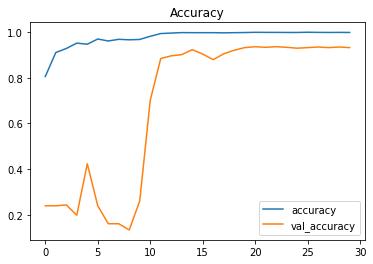

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.24181
Test Accuracy: 93.75%


In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['daisy', 'tulip', 'rose', 'rose', 'tulip']


In [20]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.97      0.91      0.94        78
   dandelion       0.95      0.96      0.95       109
        rose       0.91      0.94      0.92        78
   sunflower       0.97      0.91      0.94        78
       tulip       0.89      0.96      0.92        89

    accuracy                           0.94       432
   macro avg       0.94      0.93      0.94       432
weighted avg       0.94      0.94      0.94       432



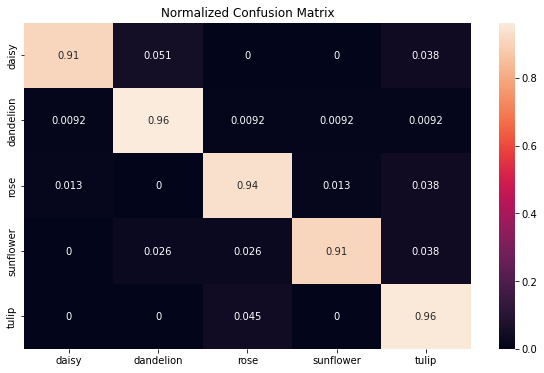

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

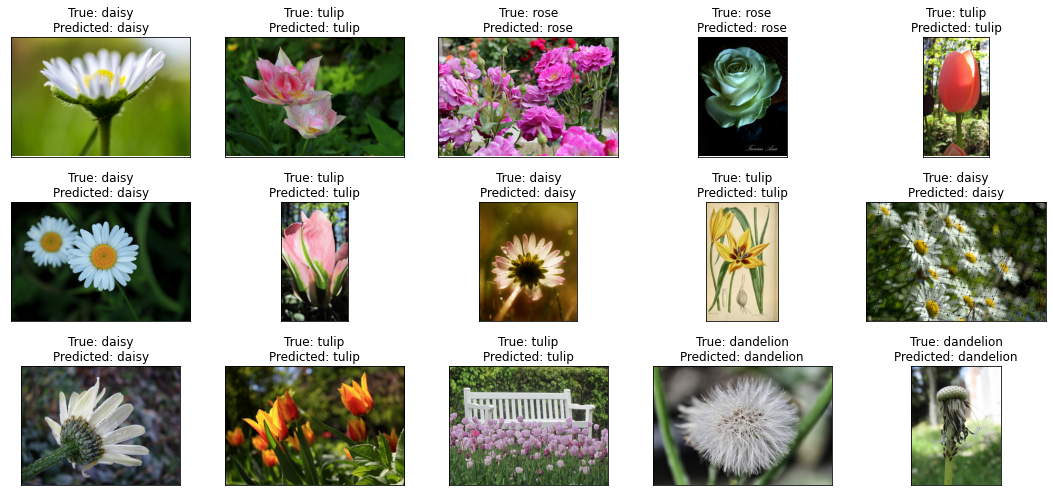

In [22]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()